In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# 1. calculate rank correlation: distribution + average

In [4]:
def calc_rank_corr_two_methods(attr1, attr2):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate rank correlation for each data point
    #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
    corrs = []
    for row in range(attr1.shape[0]):
        rho, _ = spearmanr(np.abs(attr1[row, :]), np.abs(attr2[row, :]))
        corrs.append(rho)
        
    return corrs #rank correlations for each datapoint


In [5]:
def calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs):
    '''
    inputs
    expl_methods_names: dictionary with string names of explanation methods (keys=method_index, values=method_name_string)
    expl_methods_attrs: dictionary of attributions (keys=method_index, values=attributions for a model)
    
    outputs
    avg_corr_matrix: array with average rank correlation for each pair of methods
    corr_distr: dictionary with distribution of rank correlation for each method pair
    '''
    #initiate dict to store distribution of rank correlation for each method pair
    corr_distr = {}
    
    #initiate array to store average rank correlation for each method pair
    num_expl_methods = len(expl_methods_attrs)
    avg_corr_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill corr_distr and avg_corr_matrix 
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        corrs = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b]) #rank correlations for each datapoint
        #corr_distr
        
        if a != b:
            corr_distr[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = corrs
        #avg_corr_matrix
        avg_corr_matrix[a, b] = np.mean(corrs) 
        avg_corr_matrix[b, a] = avg_corr_matrix[a, b]
        
    return corr_distr, avg_corr_matrix
    

In [6]:
def plot_corr_matrix(corr_matrix, plot_path, 
                     labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.savefig(plot_path, facecolor='white', transparent=False)

In [7]:
#plot boxplots, function
def plot_rank_corr_boxplots(corr_distr, plot_path):
    '''
    corr_distr: output of calc_rank_corr_all_methods()
    '''
    #plot
    fig, axes = plt.subplots(1, 1, figsize =(5.5, 5.5))
    axes.set(ylim=(-1.1, 1.1))
    bp = sns.boxplot(data=list(corr_distr.values()), color='cornflowerblue')
    bp.set_xticklabels(list(corr_distr.keys()), rotation=90)
    bp.set(xlabel='Method pair', ylabel='Rank correlation');
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')

In [8]:
#combine all functions
def rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path_first_part, 
                              labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    #calculate rank correlation, distribution and average
    corr_distr, avg_corr_matrix = calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs)
    
    #plot boxplots of distribution of rank correlations for each method pair
    plot_path=f'{plot_path_first_part}_distr.png'
    plot_rank_corr_boxplots(corr_distr, plot_path)
    
    #plot heatmap of average rank correlations for each method pair
    plot_path=f'{plot_path_first_part}_avg.png'
    plot_corr_matrix(avg_corr_matrix, plot_path, labels)
    
    return corr_distr, avg_corr_matrix

# 2. create plots for each model

### NN + logistic

----------- calculating rank correlation for nn
[[ 1.          0.80026991  0.0223636   0.59251768  0.59753212  0.01551957]
 [ 0.80026991  1.          0.18859649  0.41326731  0.42150636  0.18435512]
 [ 0.0223636   0.18859649  1.         -0.00597737 -0.02040176  0.98026316]
 [ 0.59251768  0.41326731 -0.00597737  1.          0.991075   -0.00284443]
 [ 0.59753212  0.42150636 -0.02040176  0.991075    1.         -0.01682497]
 [ 0.01551957  0.18435512  0.98026316 -0.00284443 -0.01682497  1.        ]]
----------- calculating rank correlation for nn_logistic
[[1.         0.81383748 0.38198863 0.59712072 0.59712072 0.38198863]
 [0.81383748 1.         0.40970214 0.35427903 0.35427903 0.40970214]
 [0.38198863 0.40970214 1.         0.02025203 0.02025203 1.        ]
 [0.59712072 0.35427903 0.02025203 1.         1.         0.02025203]
 [0.59712072 0.35427903 0.02025203 1.         1.         0.02025203]
 [0.38198863 0.40970214 1.         0.02025203 0.02025203 1.        ]]


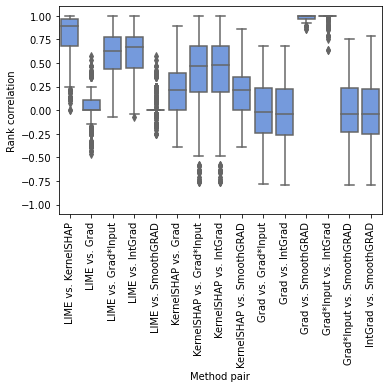

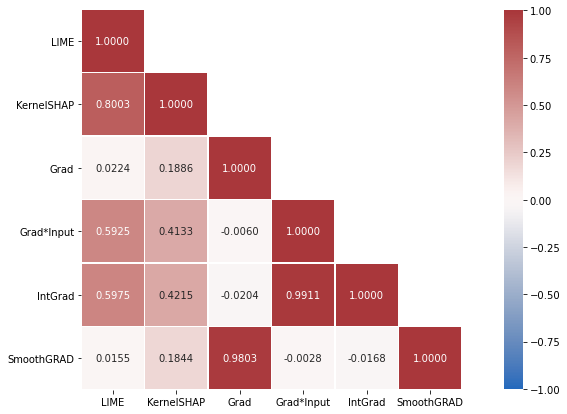

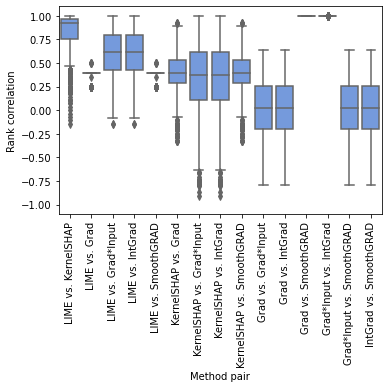

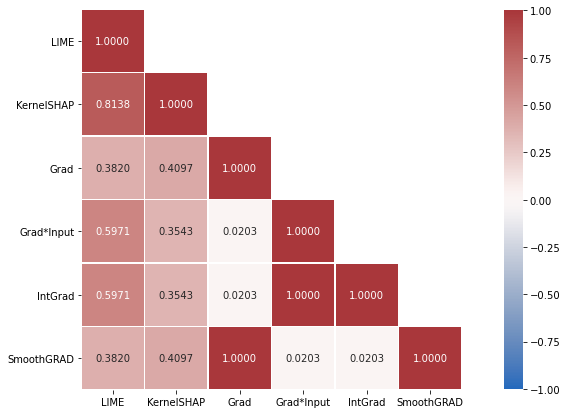

In [9]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}

    print(f'----------- calculating rank correlation for {m}')
    plot_path_first_part=f'figures/rank_corr_{m}'
    corr_distr, avg_corr_matrix = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path_first_part)
    print(avg_corr_matrix)
    

### RF + GB

----------- calculating rank correlation for rf
[[1.         0.26257953]
 [0.26257953 1.        ]]
----------- calculating rank correlation for gb
[[1.         0.49390303]
 [0.49390303 1.        ]]


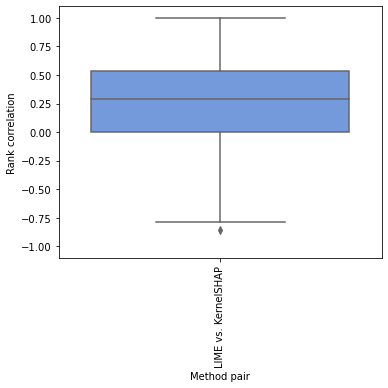

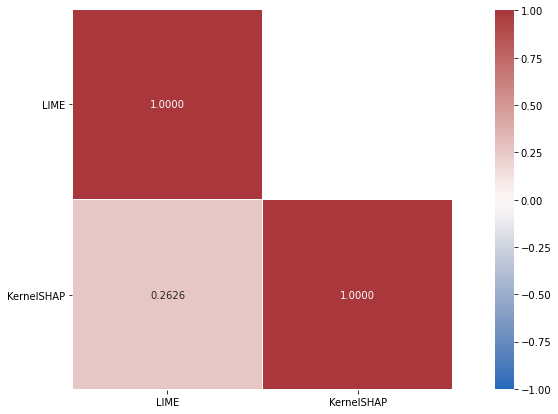

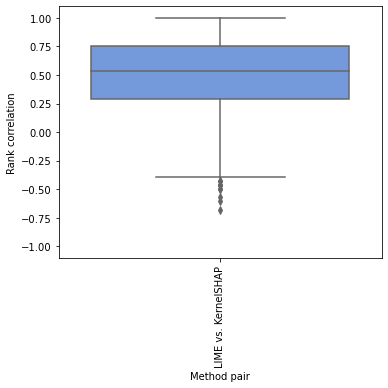

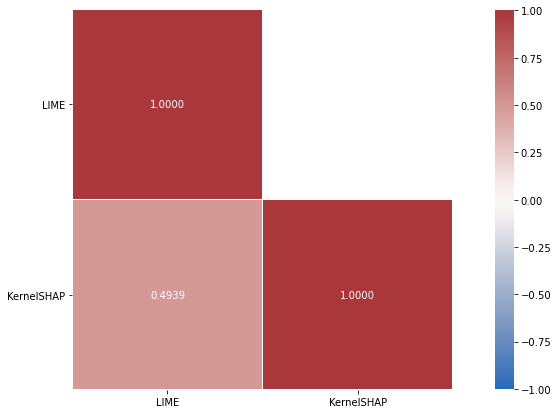

In [10]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}


for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}      

    print(f'----------- calculating rank correlation for {m}')
    plot_path_first_part=f'figures/rank_corr_{m}'
    corr_distr, avg_corr_matrix = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, 
                                                            plot_path_first_part, labels=['LIME', 'KernelSHAP'])
    print(avg_corr_matrix)